In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams, colors
from tqdm import tqdm
import emcee
import corner
import plotly.express as px
import plotly.graph_objects as go
import re
import glob

%matplotlib inline
# figure size in inches
rcParams['figure.figsize'] = 12,8
rcParams['axes.formatter.useoffset'] = False

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Combining theory and data

We spent the first few notebooks looking into tidal decay theory and ranking planets by what we theoretically believe their predicted value to be. In the following notebooks we explore fitting models to real transit data to get an idea of the posterior distribution over decay rate.

Now let's try combinining these two sources of data to rank which planets we'd like to investigate further.

The information we have:

* Theoretical predicted dP/dE for each planet
* Observed mean and error in dP/dE for each planet
* Properties of each star-planet system (mass, density, semi-major-axis, stellar radius, stellar mass)
* Formulae that describe roughly how posterior dP/dE variance changes with observational parameters like transit count, spacing and measurement uncertainty

What we want to know:

1. Which candidates are most interesting to target for follow up studies? i.e. which show both theoretical and observed decay, but the observation has large uncertainty.

2. Are there any discrepancies between theory and observation? i.e. theoretical dP/dE does not line up with the distribution (however large) of observed dP/dE. Is the theory over-predicting decay or is the observed decay greater than the theory, which could perhaps point to TTV caused by other phenomena like precession or companion planets.

#### Theory vs observation

* Scatter plot of theoretical predicted dP/dE vs observed dP/dE, with error bars on the observations and a 45 degree line representing theory = observation. Highlight the ones that are different and do not agree, highlight the ones that do agree but have high observed variance.

In [2]:
theoretical_df = pd.read_csv("./results/3_theoretical_decay.csv", index_col=0)
predicted_dp_de = theoretical_df["-dP/dE [s/epoch]"] * 1000 # ms/epoch
predicted_dp_de.index = theoretical_df["Planet Name"]
predicted_dp_de.head()

Planet Name
11 Com b      3.905296e-02
11 UMi b      1.842227e-01
14 And b      3.987191e-03
14 Her b      1.610807e-09
16 Cyg B b    4.626826e-09
Name: -dP/dE [s/epoch], dtype: float64

In [3]:
observed_df = pd.read_csv("./results/6_analytical_fit_all_planets.csv", index_col=0)
observed_df.head()

planet     mu_T0        var_T0      mu_P         var_P  mu_dP_dE_ms  \
0  HAT-P-1 -0.000315  9.296176e-08  4.465300  6.191295e-13     0.257152   
1  KELT-16       NaN           NaN       NaN           NaN          NaN   
2  WASP-10 -0.000860  2.793691e-08  3.092728  2.672736e-14    -0.215324   
3   KELT-1  0.001029  3.408804e-07  1.217495  6.184328e-14    -0.129201   
4  WASP-80       NaN           NaN       NaN           NaN          NaN   

   var_dP_dE_ms  Prob dP/dE < 0  
0      0.066996        0.160234  
1           NaN             NaN  
2      0.005032        0.998799  
3      0.002816        0.992547  
4           NaN             NaN

In [4]:
for i, row in tqdm(observed_df.iterrows()):
    planet = row.planet.lower()
    components = planet.split("-")
    for _, t_row in theoretical_df.iterrows():
        t_planet = t_row["Planet Name"].lower()
        t_components = t_planet.replace(" ", "-").split("-")
        match = all(x in t_components for x in components)
        if match:
            observed_df.at[i, "t_planet"] = t_row["Planet Name"]
            break

71it [00:16,  4.38it/s]


In [5]:
df = observed_df.merge(theoretical_df, how="inner", left_on="t_planet", right_on="Planet Name").copy()
df = df.set_index("planet", drop=False)
df = df.drop(index=["WASP-33"])

In [6]:
df["theoretical_dP_dE_ms"] = df["-dP/dE [s/epoch]"] * 1000
df["observed_dP_dE_ms"] = -df.mu_dP_dE_ms.where(df.mu_dP_dE_ms < 0.0, 0.0)
df["error_observed_dP_dE_ms"] = np.sqrt(df.var_dP_dE_ms)
df["error_theoretical_dP_dE_ms"] = df["-dP/dE error [ms/epoch]"]

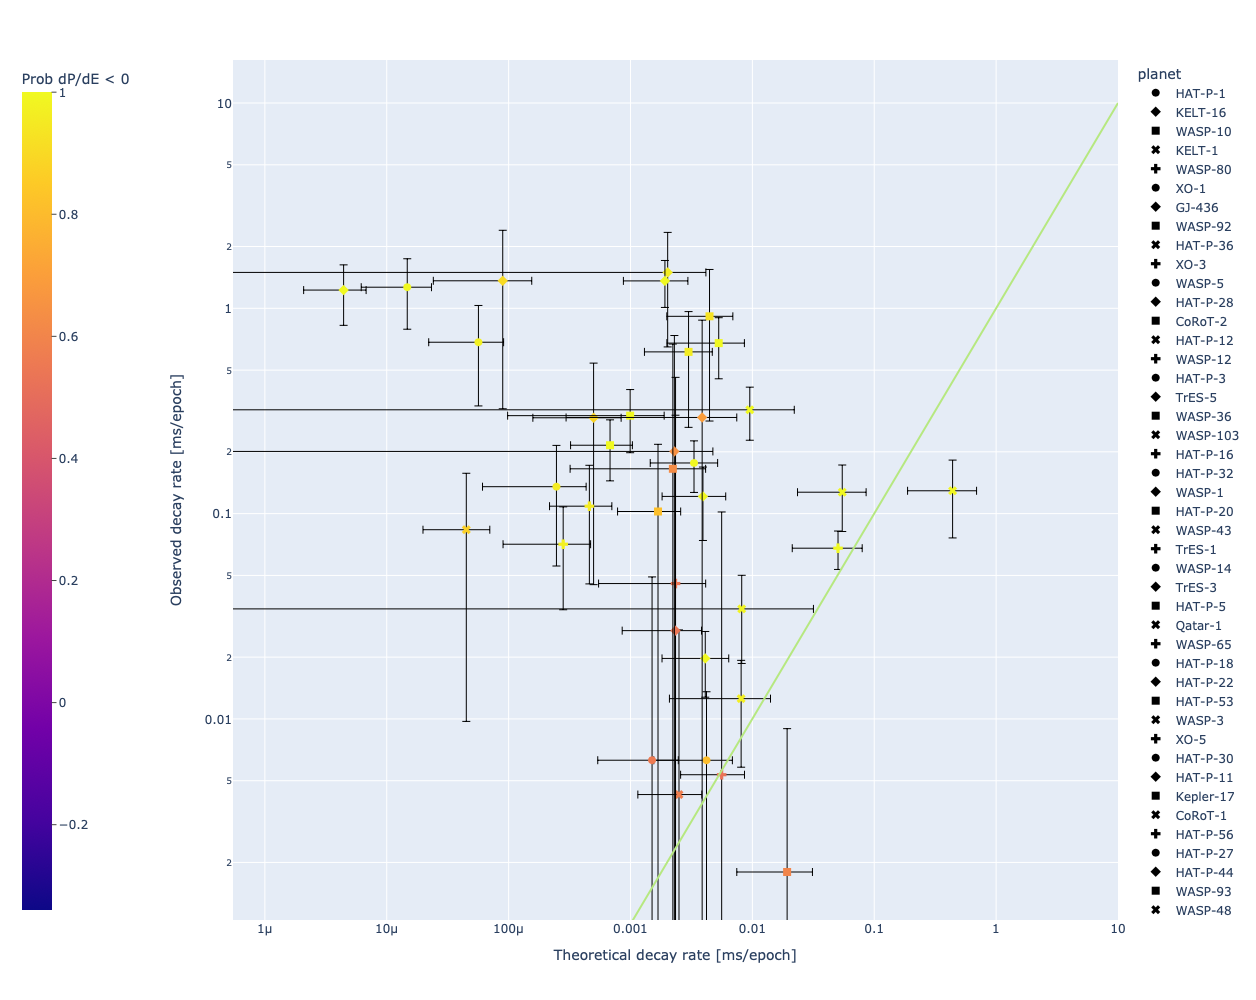

In [14]:
fig = px.scatter(df, x="theoretical_dP_dE_ms", y="observed_dP_dE_ms", symbol="planet", log_x=True, log_y=True,
                 error_x="error_theoretical_dP_dE_ms",
                 error_y="error_observed_dP_dE_ms",
                 color="Prob dP/dE < 0",
                 labels={"theoretical_dP_dE_ms": "Theoretical decay rate [ms/epoch]", "observed_dP_dE_ms": "Observed decay rate [ms/epoch]"},
                 height=1000)

fig.update_traces(marker={'size': 8})
fig.update_traces(error_x={'thickness': 1})
fig.update_traces(error_y={'thickness': 1})

x = [0, 10]
fig.add_traces(go.Scatter(x=x, y=x, mode='lines'))

fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.25, ticks="outside"))
fig.show()

There are some issues here: perhaps our value of Q* is not appropriate for all these systems.

Nevertheless, I claim that the interesting systems to study are those for which theory and observation may potentially agree, but the uncertainty in the observed decay rate is too large to say with any degree of certainty.

Those that disagree: why do they disagree. Perhaps our theoretical model is wrong, or something else is causing their decay?

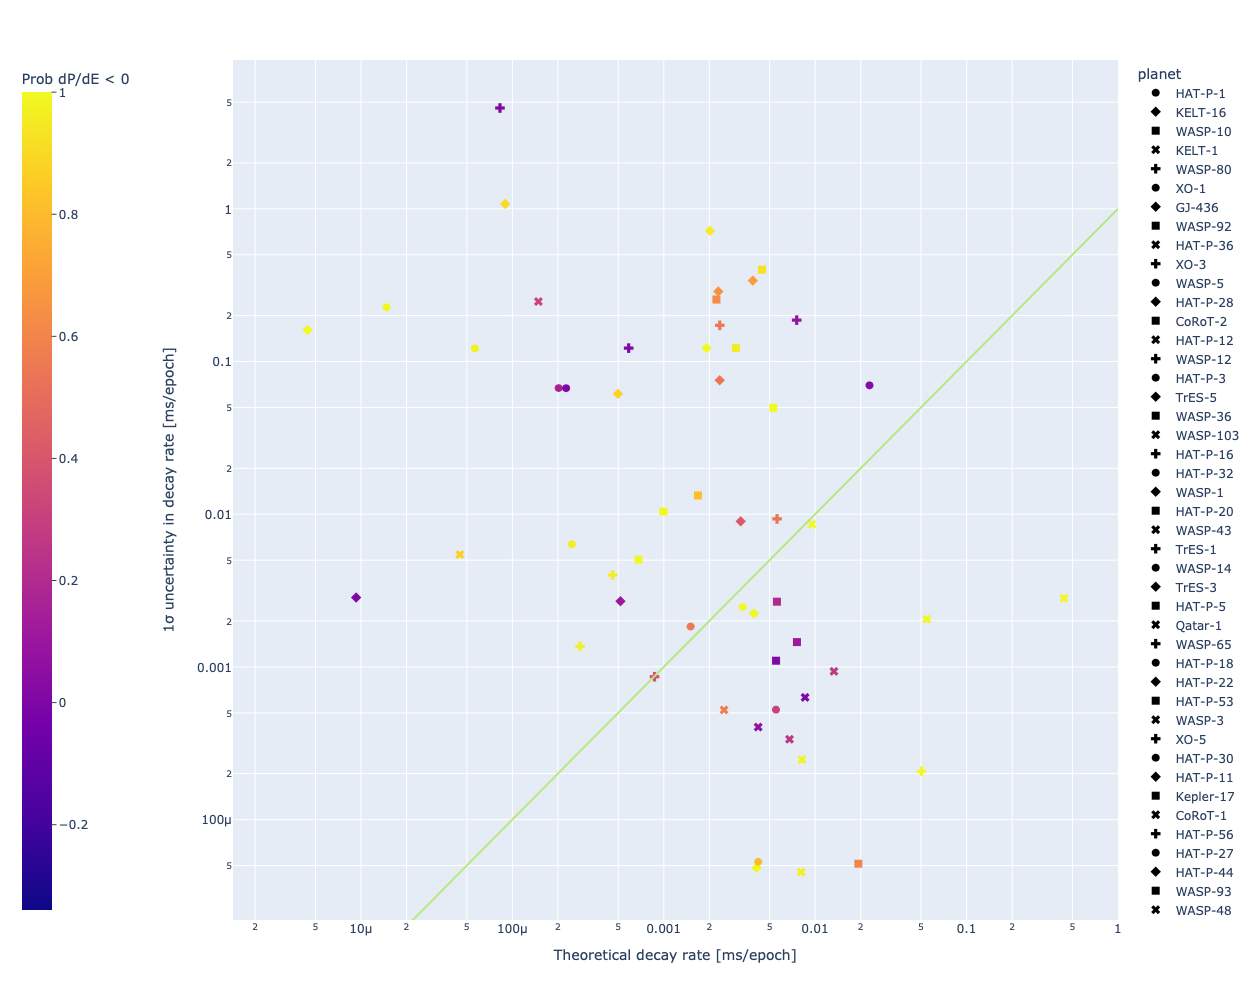

In [15]:
fig = px.scatter(df, x="theoretical_dP_dE_ms", y="var_dP_dE_ms", color="Prob dP/dE < 0", symbol="planet", log_x=True, log_y=True, 
                 labels={"theoretical_dP_dE_ms": "Theoretical decay rate [ms/epoch]", "var_dP_dE_ms": "1σ uncertainty in decay rate [ms/epoch]"},
                 height=1000)
fig.update_traces(marker={'size': 8})

x = [0, 1]
fig.add_traces(go.Scatter(x=x, y=x, mode='lines'))

fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=-0.25, ticks="outside"))
fig.show()

My assertion is that we want to investigate those systems that have high theoretical decay. Those with low observed variance are hopefully confirmed to be decaying (yellow), or can be confirmed with some further measurement to bring down the observed variance.

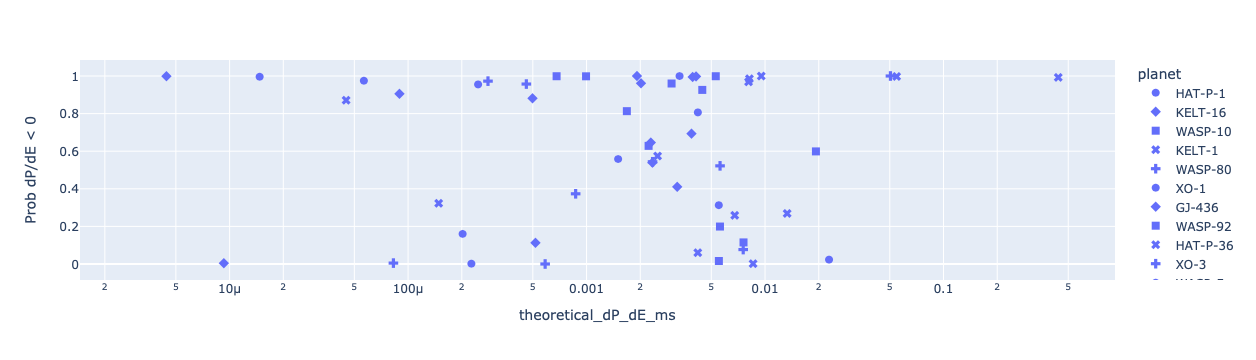

In [244]:
fig = px.scatter(df, x="theoretical_dP_dE_ms", y="Prob dP/dE < 0", symbol="planet", log_x=True, log_y=False, height=1000)
fig.update_traces(marker={'size': 8})
fig.show()

#### Observational parameters vs posterior variance

* 2D heatmap plots of transit count, spacing and measurement uncertainty against posterior variance of dP/dE, probablity of decay based on observations, and theoretical dP/dE.

In [16]:
odf = pd.read_csv("./results/5_observational_parameters_effect.csv", index_col=0)
odf.planet = odf.planet.fillna("NA")
odf.head()

transit_count  transit_spacing  measurement_unc planet  \
0              3              1.0        10.368000     NA   
1              3              1.0        11.850314     NA   
2              3              1.0        13.544554     NA   
3              3              1.0        15.481020     NA   
4              3              1.0        17.694342     NA   

   prob_dP_dE_less_than_0  decay_rate_variance  log_decay_rate_variance  \
0                     NaN         4.299817e+08                 8.633450   
1                     NaN         5.617197e+08                 8.749520   
2                     NaN         7.338198e+08                 8.865589   
3                     NaN         9.586479e+08                 8.981659   
4                     NaN         1.252359e+09                 9.097729   

   marker_size  
0          1.0  
1          1.0  
2          1.0  
3          1.0  
4          1.0

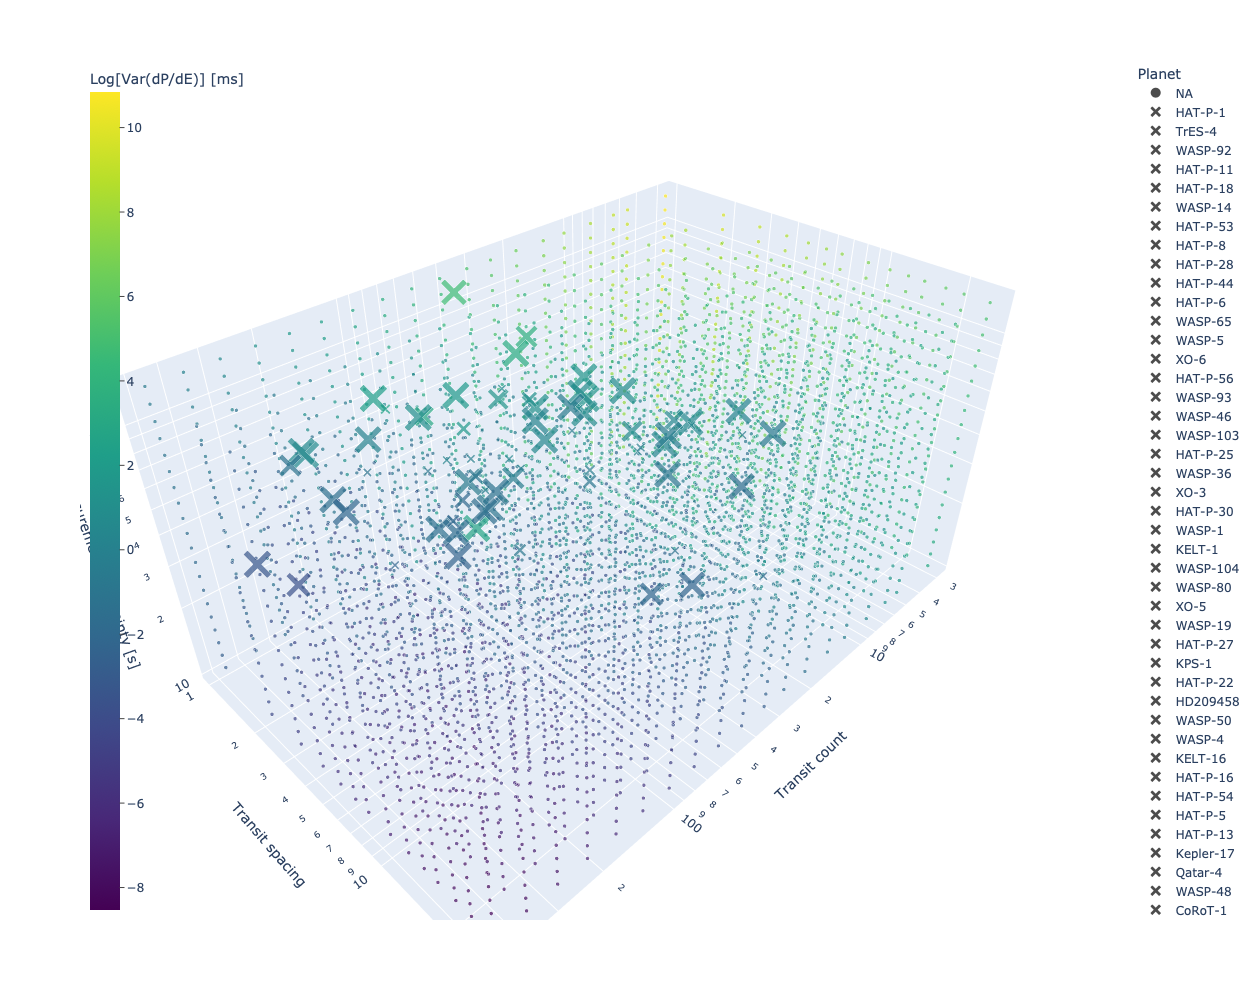

In [18]:
labels = {"measurement_unc": "Measurement uncertainty [s]", "transit_spacing": "Transit spacing", "transit_count": "Transit count", "planet": "Planet", "log_decay_rate_variance": "Log[Var(dP/dE)] [ms]"}
fig = px.scatter_3d(odf, x="transit_count", y="transit_spacing", z="measurement_unc", symbol="planet", size="marker_size", symbol_map={"NA": "circle"}, symbol_sequence=["x"], color="log_decay_rate_variance", color_continuous_scale=px.colors.sequential.Viridis, log_x=True, log_y=True, log_z=True, labels=labels, height=1000)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.show()

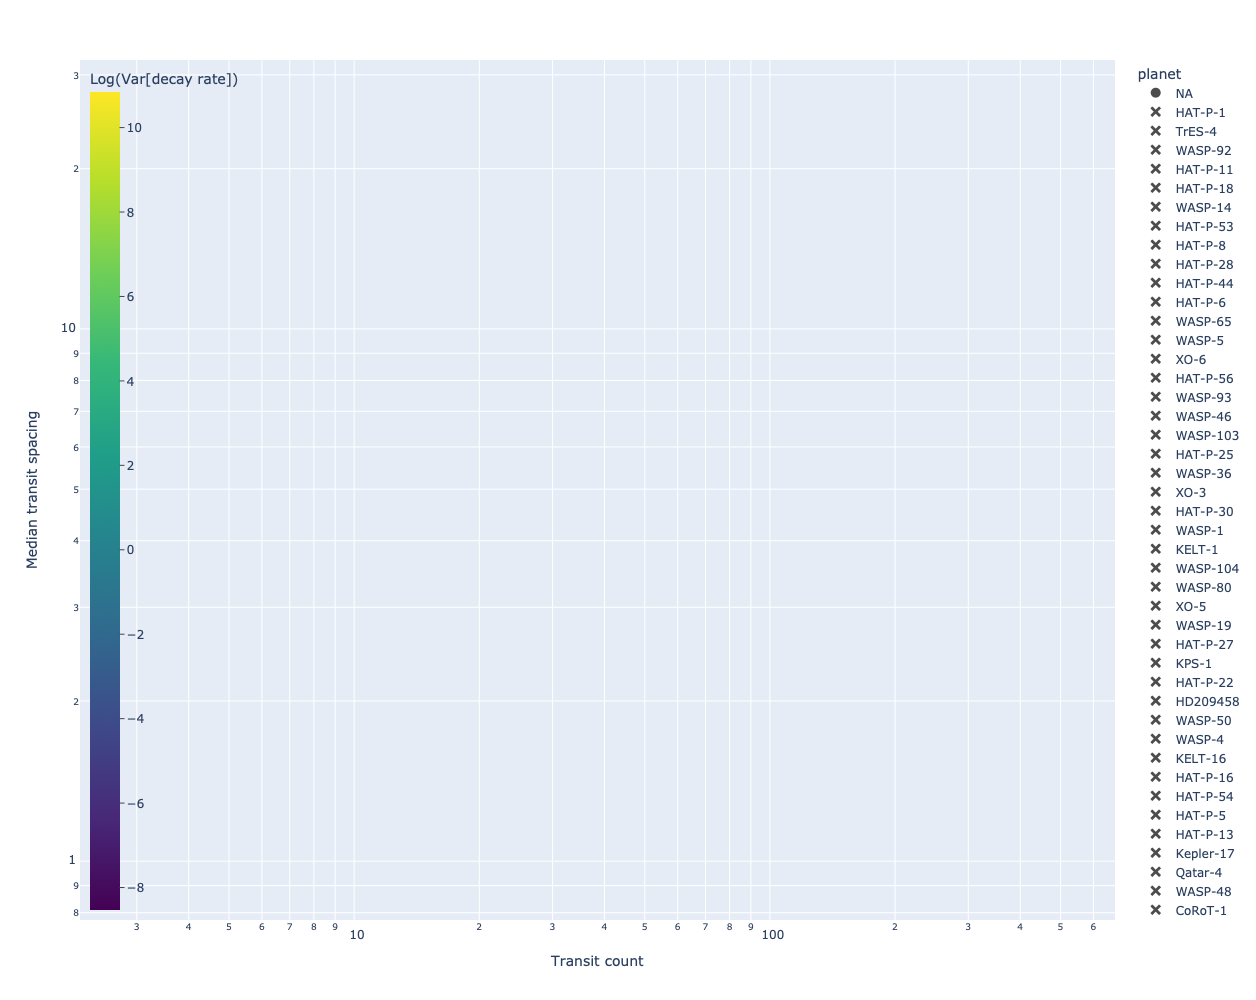

In [23]:
fig = px.scatter(odf, x="transit_count", y="transit_spacing", log_x=True, log_y=True, height=1000,
                 symbol="planet",
                 size="marker_size",
                 symbol_map={"NA": "circle"},
                 symbol_sequence=["x"],
                 color="log_decay_rate_variance",
                 color_continuous_scale=px.colors.sequential.Viridis, 
                 labels={"transit_spacing": "Median transit spacing", "transit_count": "Transit count", "log_decay_rate_variance": "Log(Var[decay rate])"},
                )
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.show()

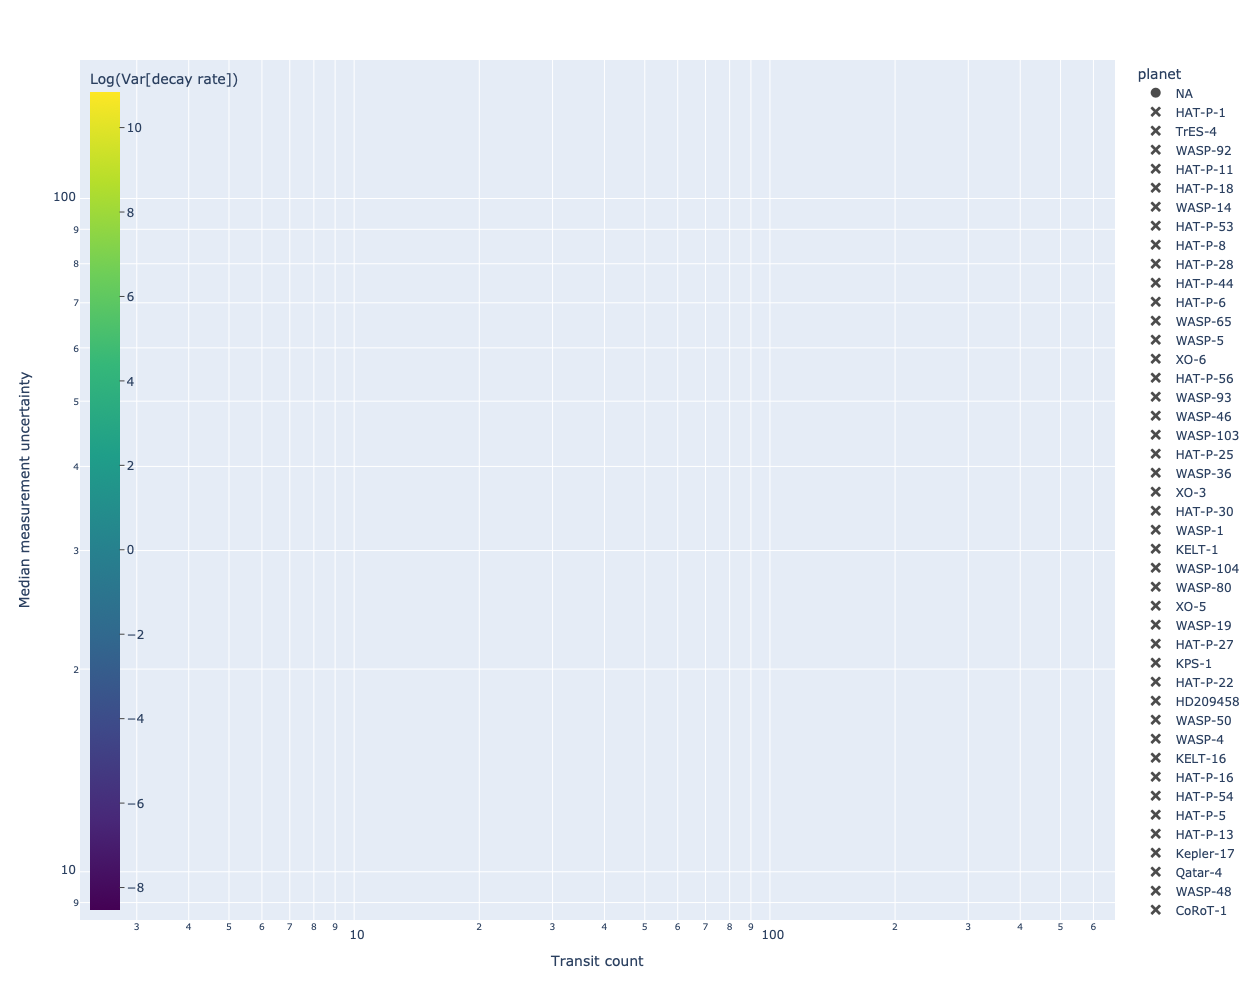

In [24]:
fig = px.scatter(odf, x="transit_count", y="measurement_unc", log_x=True, log_y=True, height=1000,
                 symbol="planet",
                 size="marker_size",
                 symbol_map={"NA": "circle"},
                 symbol_sequence=["x"],
                 color="log_decay_rate_variance",
                 color_continuous_scale=px.colors.sequential.Viridis,
                 labels={"measurement_unc": "Median measurement uncertainty", "transit_count": "Transit count", "log_decay_rate_variance": "Log(Var[decay rate])"},
                )
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.show()

In [249]:
podf = odf.merge(df["theoretical_dP_dE_ms"], how="inner", left_on="planet", right_index=True)
podf["log_theoretical_dP_dE_ms"] = np.log(podf.theoretical_dP_dE_ms)
podf.head()

transit_count  transit_spacing  measurement_unc    planet  \
2277             32              2.0           92.448   HAT-P-1   
2461             32             16.0          113.616    TrES-4   
2522             33             11.0           89.856   WASP-92   
2523             36              1.0           10.368  HAT-P-11   
2524             36              2.0           83.376  HAT-P-18   

      prob_dP_dE_less_than_0  decay_rate_variance  log_decay_rate_variance  \
2277                0.652677          4630.185723                 3.665598   
2461                0.937997             1.707349                 0.232322   
2522                0.999101             4.088946                 0.611611   
2523                0.999385           512.670424                 2.709838   
2524                0.990375          2072.098590                 3.316410   

      marker_size  theoretical_dP_dE_ms  log_theoretical_dP_dE_ms  
2277     6.526772              0.000202                 -8.506585  
2461     9.379967              0.002291                 -6.078698  
2522     9.991008              0.002995                 -5.810732  
2523     9.993854              0.000004                -12.327667  
2524     9.903749              0.000015                -11.125259

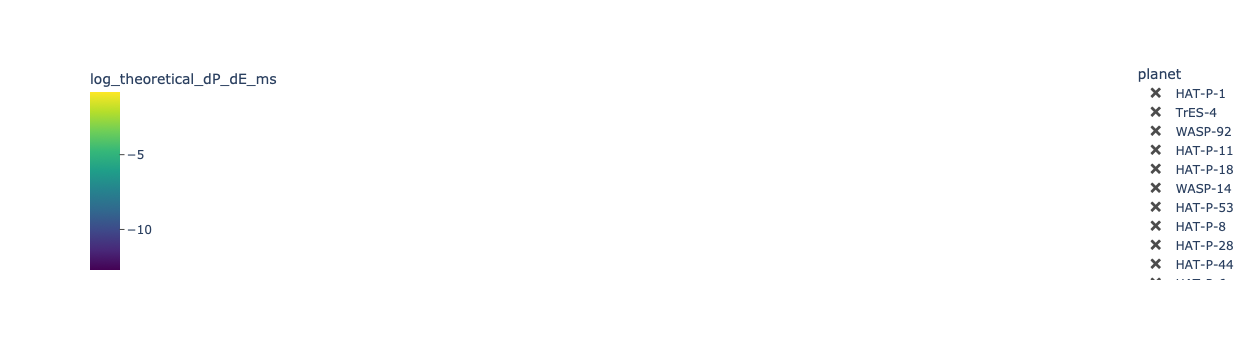

In [250]:
labels = {"prob_dP_dE_less_than_0": "Prob. of decay", "median_spacing": "Median transit spacing", "transit_count": "Transit count", "median_error_seconds": "Median measurement uncertainty [s]"}
fig = px.scatter_3d(podf, x="transit_count", y="transit_spacing", z="measurement_unc", 
                    symbol="planet", symbol_sequence=["x"], size="marker_size",
                    color="log_theoretical_dP_dE_ms", color_continuous_scale=px.colors.sequential.Viridis, 
                    log_x=True, log_y=True, log_z=True, labels=labels, height=1000)
fig.update_layout(coloraxis_colorbar=dict(yanchor="top", y=1, x=0,
                                          ticks="outside"))
fig.show()

By viewing the 3D plot of observational parameters vs theoretical decay rate, we can identify planets that in theory should decay a lot, but do not yet have good observations.